# Modelos lineares

Até o momento vimos o processo de construção de uma solução de machine learning:

- Aquisição e preparo dos dados
- Definição da métrica de desempenho
- Separação em conjuntos de treinamento e teste
- Investigação dos dados
- Escolha de modelo:
    - Avaliação de vários modelos usando validação cruzada
    - Comparação de métricas de desempenho
    - Ajuste de hiperparâmetros
- Treinamento final
- Teste final
- Etapas de producão
    - Relatório final
    - Operacionalização do modelo em produção

Porém neste processo todo nossos modelos eram "caixas pretas", não conhecemos nada sobre como os modelos funcionam!

Nesta aula vamos começar a investigar os modelos lineares: o que são, e como treina-los. Vamos aprender sobre regressão linear, algoritmos de treinamento, regressão polinomial, overfitting versus underfitting. Na aula seguinte vamos discutir o *tradeoff bias/variance*, estratégias de regularização, regressão logística e softmax.

**Atividade:**

Sem olhar no material de suporte, liste no papel os passos fundamentais de um projeto de machine learning. Vocë tem que conhecer isso de memória!

Vamos inicializar algumas bibliotecas padrão de nosso trabalho:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

RAND_SEED = 42

np.random.seed(RAND_SEED)

# Revisão

## Modelo

Em todo problema de machine learning uma amostra de entrada é um vetor 

$$\mathbf{x} = (x_1, x_2, \cdots, x_n)$$

de $n$ valores (características ou *features*). (Usaremos fontes em negrito para indicar vetores e matrizes.) 

Em notação matricial, os vetores são matrizes-coluna:

$$
\mathbf{x} = \left[
\begin{matrix}
x_1 \\
x_2 \\
\vdots \\
x_n
\end{matrix}
\right]
$$

Vamos trabalhar com as duas notações (vetores e matrizes-coluna) de modo intercambiável, e que ficará evidente no contexto de uso.

Uma amostra de saída é um valor que se supõe depender da entrada. Se o valor de saída é contínuo temos um problema de **regressão**, e se o valor é categórico (trata-se de uma classe ou categoria) temos um problema de **classificação**.

Um modelo de machine learning é uma função que permite estimar o valor de saída para uma dada amostra de entrada. Esta função depende de **parâmetros** $\mathbf{\theta}$, que representam os "ajustes" desta função. Ou seja:

$$y_{\text{estimado}} = \hat{y} = h_{\mathbf{\theta}}\left(\mathbf{x}\right)$$

## Erro

O objetivo principal em um projeto de machine learning é encontrar um modelo que produza boas estimativas, ou seja, estimativas que se aproximem dos valores reais. *Treinamento* é ajustar os parâmetros $\mathbf{\theta}$ para conseguir melhores estimativas. 

Uma estimativa é boa se o **erro** entre a estimativa e o valor real é baixo. A definição do erro depende do problema em questão. Se for uma regressão, então uma medida razoável de erro para uma dada amostra é a diferença entre o valor real e o valor estimado:

$$\text{erro}\left(\mathbf{x}, y_{real}, \mathbf{\theta} \right) = y_{\text{estimado}} - y_{\text{real}} = h_{\mathbf{\theta}}\left(\mathbf{x}\right) - y_{\text{real}}$$

Se desejamos uma métrica positiva de erro, podemos adotar:

- o valor absoluto do erro: $\left| \,\text{erro}\left(\mathbf{x}, y_{real}, \mathbf{\theta} \right) \,\right|$, ou 
- o valor quadrático do erro: $\text{erro}\left(\mathbf{x}, y_{real}, \mathbf{\theta} \right)^2$

Se for um problema de classificação, então o erro pode ser simplesmente o resultado da comparação entre a classe real e a classe estimada.

## Erro sobre um conjunto de amostras

Será que um modelo é bom? Uma forma de responder esta questão é avaliar o erro médio do classificador sobre um conjunto de exemplos. 

Para ilustrar essa ideia, vamos considerar um problema de regressão. Seja $\left(\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \cdots, \mathbf{x}^{(m)}\right)$ uma lista de $m$ amostras, e $\left(y_{\text{real}}^{(1)}, y_{\text{real}}^{(2)}, \cdots, y_{\text{real}}^{(m)}\right)$ os valores dependentes correspondentes. 

Vamos representar essa informação na forma de uma matriz $\mathbf{X}$ para as amostras e um vetor $\mathbf{y}_{\text{real}}$ para os valores dependentes, ou seja:

$$
\mathbf{X} = \left[
\begin{matrix} 
\left(\mathbf{x}^{(1)}\right)^{T} \\
\left(\mathbf{x}^{(2)}\right)^{T} \\
\vdots \\
\left(\mathbf{x}^{(m)}\right)^{T} \\
\end{matrix}
\right]
\  \text{,} \quad
\mathbf{y}_{\text{real}} = \left[
\begin{matrix}
y_{\text{real}}^{(1)} \\
y_{\text{real}}^{(1)} \\
\vdots \\
y_{\text{real}}^{(1)} \\
\end{matrix}
\right]
$$

O erro quadrático médio é (surpresa!) a média do erro quadrático sobre o conjunto de amostras:

$$
\varepsilon^2\left(\mathbf{X}, \mathbf{y}_{\text{real}}, \mathbf{\theta}\right) = 
\frac{1}{m} \sum_{i=1}^{m} \left(h_{\mathbf{\theta}}\left(\mathbf{x}^{(i)}\right) - y_{\text{real}}^{(i)}\right)^2
$$

É comum usarmos a raiz quadrada de $\varepsilon^2\left(\mathbf{X}, \mathbf{y}_{\text{real}}, \mathbf{\theta}\right)$, para que o erro esteja descrito nas mesmas unidades de medida da variável dependente. Obtemos então a medida de erro médio conhecida como RMSE (*Root Mean Squared Error*), muito usada em problemas de regressão.

$$
\text{RMSE}\left(\mathbf{X}, \mathbf{y}_{\text{real}}, \mathbf{\theta}\right) 
= 
\sqrt{\varepsilon^2\left(\mathbf{X}, \mathbf{y}_{\text{real}}, \mathbf{\theta}\right)}
=
\sqrt{
    \frac{1}{m} 
    \sum_{i=1}^{m} 
        \left(h_{\mathbf{\theta}}\left(\mathbf{x}^{(i)}\right) - y_{\text{real}}^{(i)}\right)^2
}
$$

## Treinamento

Treinar um modelo é achar os parâmetros do modelo que minimizam o erro médio deste em um conjunto de amostras de treinamento. Por exemplo, para o problema de regressão e usando RMSE como métrica de desempenho, temos matematicamente:

$$
\mathbf{\theta}_{\text{opt}} = \text{arg min}_{\mathbf{\theta}}\left\{\text{RMSE}\left(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}, \mathbf{\theta}\right)\right\}
$$

Para procurar $\mathbf{\theta}_{\text{opt}}$ temos que aplicar um **algoritmo de treinamento** ao nosso modelo e nossas amostras de treinamento. Para cada modelo e métrica de desempenho existe um algoritmo de treinamento. Alguns algoritmos de treinamento são versáteis, e são aplicáveis a vários tipos de modelo - por exemplo, o *método do máximo declive* (**gradient descent**).

$$\mathbf{\theta}_{\text{opt}} = \text{modelo.fit}(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}})$$

Existem parâmetros que não são ajustáveis neste processo, e seus valores devem ser passados para o algoritmo de treinamento. Por exemplo: número máximo de iterações do método de treinamento, valor do parâmetro de regularização, etc. Estes parâmetros extras sao chamados de **hiperparâmetros**. Portanto, é mais correto escrever a expressão acima como:

$$\text{modelo} = \text{Modelo}(\mathbf{\theta}_{\text{hiper}})$$

$$\mathbf{\theta}_{\text{opt}} = \text{modelo.fit}(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}})$$

## Usando o modelo treinado para fazer predições

Finalmente, quando temos o modelo treinado (ou seja, encontramos os parâmetros ótimos $\mathbf{\theta}$), podemos usá-lo para fazer predições: seja $\mathbf{x}_{\text{novo}}$ uma nova amostra, então a predição $\hat{y}$ do modelo é calculada como:

$$\hat{y} = h_{\mathbf{\theta}_{\text{opt}}; \mathbf{\theta}_{\text{hiper}}}\left(\mathbf{x}_{\text{novo}}\right)$$

Ou, em pseudo-código:

$$\text{modelo} = \text{Modelo}(\mathbf{\theta}_{\text{hiper}})$$

$$\mathbf{\theta}_{\text{opt}} = \text{modelo.fit}(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}})$$

$$\hat{y} = \text{modelo.predict}(\mathbf{x}_{\text{novo}})$$

**Atividade:** 

Isto que foi apresentado é a essência do machine learning para classificação e regressão. Tente explicar, com a formulação matemática adequada, os seguintes conceitos:

- Amostra

- Característica

- Modelo

- RMSE

- Treinamento

- Predição

O objetivo é conseguir explicar e escrever as fórmulas correspondentes SEM PRECISAR OLHAR NO MATERIAL DE SUPORTE. Estude o material de suporte o quanto quiser, feche o notebook, e responda a atividade no papel.

# Regressão linear

## Modelo

Em um modelo de regressão linear, desejamos obter uma predição de valor $\hat{y}$ como uma combinação linear dos valores das *features* mais um termo de *offset*.

$$\mathbf{\theta} = (\theta_0, \theta_1, \cdots, \theta_n)$$

$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n$$

Em notação matricial:

$$\hat{y} = \mathbf{x}^{T} \mathbf{\theta}$$

onde o vetor $\mathbf{x}$ de características da amostra é formado pelas características originais e por uma "característica extra" que é o valor $1$. Ou seja:

$$\mathbf{x} = \left[
\begin{matrix}
1 \\
x_1 \\
x_2 \\
\vdots \\
x_n
\end{matrix}
\right]$$

Para um dado conjunto de treinamento, podemos representar as várias quantidades deste problema em uma notação matricial:

$$
\mathbf{X}_{\text{train}} = \left[
\begin{matrix}
\left(\mathbf{x}_{\text{train}}^{(1)}\right)^{T} \\
\left(\mathbf{x}_{\text{train}}^{(2)}\right)^{T} \\
\vdots \\
\left(\mathbf{x}_{\text{train}}^{(m)}\right)^{T}
\end{matrix}
\right]
\  \text{,} \quad
\mathbf{y}_{\text{train}} = \left[
\begin{matrix}
y_{\text{train}}^{(1)} \\
y_{\text{train}}^{(2)} \\
\vdots \\
y_{\text{train}}^{(m)} \\
\end{matrix}
\right]
\  \text{,} \quad
\mathbf{\theta} = \left[
\begin{matrix}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_n
\end{matrix}
\right]
\  \text{,} \quad
\hat{\mathbf{y}} = \left[
\begin{matrix}
\hat{y}^{(1)} \\
\hat{y}^{(2)} \\
\vdots \\
\hat{y}^{(m)}
\end{matrix}
\right] = \mathbf{X}_{\text{train}} \mathbf{\theta}
$$

## Erro quadrático

Para um conjunto de amostras de treinamento, o erro quadrático médio é dado por:

$$
\varepsilon^2\left(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}, \mathbf{\theta}\right) = 
\frac{1}{m} 
  \sum_{i=1}^{m} \left(
    h_{\mathbf{\theta}}\left(\mathbf{x}_{\text{train}}^{(i)}\right) - y_{\text{train}}^{(i)}
  \right)^2 =
\frac{1}{m} 
  \sum_{i=1}^{m} \left(
    (\mathbf{x}_{\text{train}}^{(i)})^{T} \mathbf{\theta} - y_{\text{train}}^{(i)}
  \right)^2 
$$

Em notação matricial,

$$
\varepsilon^2\left(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}, \mathbf{\theta}\right) = \\
\frac{1}{m} (\mathbf{X}_{\text{train}} \mathbf{\theta} - \mathbf{y}_{\text{train}})^T 
            (\mathbf{X}_{\text{train}} \mathbf{\theta} - \mathbf{y}_{\text{train}}) = \\
\frac{1}{m} (\mathbf{\theta}^{T} \mathbf{X}_{\text{train}}^{T} - \mathbf{y}_{\text{train}}^{T})
            (\mathbf{X}_{\text{train}} \mathbf{\theta} - \mathbf{y}_{\text{train}}) = \\
\frac{1}{m} (
    \mathbf{\theta}^{T} \mathbf{X}_{\text{train}}^{T} \mathbf{X}_{\text{train}} \mathbf{\theta} 
  - \mathbf{\theta}^{T} \mathbf{X}_{\text{train}}^{T} \mathbf{y}_{\text{train}}
  - \mathbf{y}_{\text{train}}^{T} \mathbf{X}_{\text{train}} \mathbf{\theta}
  + \mathbf{y}_{\text{train}}^{T} \mathbf{y}_{\text{train}}) = \\
\frac{1}{m} (
    \mathbf{\theta}^{T} \mathbf{X}_{\text{train}}^{T} \mathbf{X}_{\text{train}} \mathbf{\theta} 
  - 2 \mathbf{\theta}^{T} \mathbf{X}_{\text{train}}^{T} \mathbf{y}_{\text{train}}
  + \mathbf{y}_{\text{train}}^{T} \mathbf{y}_{\text{train}})
$$

Note que se $\mathbf{X}_{\text{train}}$ e $\mathbf{y}_{\text{train}}$ são quantidades fixas, a única variável aqui é $\mathbf{\theta}$.

## Gradiente do erro

Cálculo matricial: https://en.wikipedia.org/wiki/Matrix_calculus

Extraindo as derivadas parciais da função $\varepsilon^2\left(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}, \mathbf{\theta}\right)$ em relação aos termos $\theta_i$ temos:

$$
\nabla_{\mathbf{\theta}} \varepsilon^2\left(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}, \mathbf{\theta}\right) = \\
\frac{1}{m} (
    2 \mathbf{X}_{\text{train}}^{T} \mathbf{X}_{\text{train}} \mathbf{\theta} 
  - 2 \mathbf{X}_{\text{train}}^{T} \mathbf{y}_{\text{train}})
$$

## A Equação Normal

Nosso objetivo é achar o valor dos parâmetros $\mathbf{\theta}$ que minimiza $\varepsilon^2\left(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}, \mathbf{\theta}\right)$. Para tanto, vamos resolver a equação 

$$\nabla_{\mathbf{\theta}} \varepsilon^2\left(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}, \mathbf{\theta}\right) = \mathbf{0}$$

onde $\mathbf{0}$ é uma matriz-coluna de $m$ zeros.

$$
\nabla_{\mathbf{\theta}} \varepsilon^2\left(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}, \mathbf{\theta}\right) = 
\mathbf{0} \\
\Leftrightarrow 
\frac{1}{m} (
    2 \mathbf{X}_{\text{train}}^{T} \mathbf{X}_{\text{train}} \mathbf{\theta} 
  - 2 \mathbf{X}_{\text{train}}^{T} \mathbf{y}_{\text{train}}) = \mathbf{0} \\
\Leftrightarrow
  \mathbf{X}_{\text{train}}^{T} \mathbf{X}_{\text{train}} \mathbf{\theta} = 
  \mathbf{X}_{\text{train}}^{T} \mathbf{y}_{\text{train}} \\
\Leftrightarrow
  \mathbf{\theta} = (\mathbf{X}_{\text{train}}^{T} \mathbf{X}_{\text{train}})^{-1}
  \mathbf{X}_{\text{train}}^{T} \mathbf{y}_{\text{train}}  
$$

Esta última linha é conhecida como **equação normal** do problema de regressão linear. Será que corresponde a um ponto de mínimo? Calculando a segunda derivada do erro quadrático temos:

$$
\nabla^{2}_{\mathbf{\theta}} \varepsilon^2\left(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}, \mathbf{\theta}\right) = \frac{2}{m} \mathbf{X}_{\text{train}}^{T} \mathbf{X}_{\text{train}}
$$

Como a matriz resultante é positiva-definida (https://en.wikipedia.org/wiki/Positive-definite_matrix), temos a segurança de que a resposta da equação normal é realmente um ponto de mínimo!

## Usando a equação normal para treinar uma regressão linear

Chegamos finalmente ao nosso primeiro algoritmo de treinamento do curso de machine learning! Vamos treinar um modelo de regressão linear usando a equação normal.

A vantagem de se usar a equação normal é que a solução final é obtida diretamente por uma fórmula. A desvantagem é que o cálculo desta fórmula não escala bem com o número de *features* do problema, porque a matriz quadrada $\mathbf{X}_{\text{train}}^{T} \mathbf{X}_{\text{train}}$ deve ser invertida e esta tem tamanho $n \times n$. Se o número de *features* for muito alto (e.g. pixels em uma imagem) o custo desta operação é alto.

**Atividade:** Qual a complexidade computacional de se inverter uma matriz?

**R:** entre O(n^3) e O(n^2)

**Atividade:** Qual a complexidade computacional do treinamento do regressor linear via equação normal, em termos de:

- $n$: número de *features*, e
- $m$: número de amostras de treinamento?

**R:**
Segundo https://math.stackexchange.com/questions/84495/computational-complexity-of-least-square-regression-operation/84503#84503

A resposta seria $O(n^2m)$

**Atividade:** Em função dos resultados acima, você recomendaria o uso da equação normal em um problema:

1. Com poucas amostras de treinamento e muitas *features*?

2. Com muitas amostras de treinamento e poucas *features*?

**R:**

1. Recomendaria a equação normal, pois ter a complexidade quadratica ao número de features
2. Recomendaria a inversão de matriz, pois o valor de $m * n^2$ deve ser maior do que $n^3$ (que seria o caso do pior algoritmo para a inversão da matriz, sabendo que existem opções melhores, como $O(n^{2.3})$)

Vamos gerar alguns pontos de dados para testar nossa regressão linear. Nossa função linear real será $f(x) = 3 x + 4$ e á esta adicionaremos ruído gaussiano de média zero e desvio padrão unitário:

In [2]:
m = 100

X = 2 * np.random.rand(m, 1)  # Gera m pontos aleatórios entre 0 e 2.
y = 4 + 3 * X + np.random.randn(m, 1)

**Pergunta:** Quais são os parâmetros ótimos esperados ao se treinar um modelo de regressão linear sobre dados gerados por esta código?

**R:** $\theta_0 = 4, \theta_1 = 3$

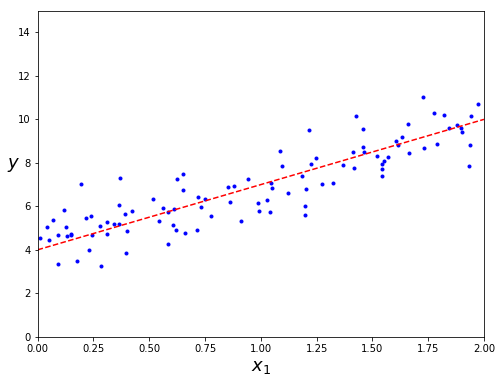

In [3]:
X_aux = np.array([[0.0], [2.0]])
y_aux = 4 + 3*X_aux

plt.figure(figsize=(8,6))
plt.plot(X, y, "b.")
plt.plot(X_aux, y_aux, "r--")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Para usar a equação normal temos que aumentar a matriz de amostras de treinamento com uma coluna extra de valores $1$:

In [4]:
print('Tamanho original da matriz de amostras: {}'.format(X.shape))
print('Algumas das amostras originais:\n{}'.format(X[:5]))

# Adicionando uma coluna de 1s.
X_b = np.c_[np.ones((m, 1)), X]

print('Tamanho da matriz de amostras aumentada: {}'.format(X_b.shape))
print('Algumas das amostras da matriz aumentada:\n{}'.format(X_b[:5]))


Tamanho original da matriz de amostras: (100, 1)
Algumas das amostras originais:
[[0.74908024]
 [1.90142861]
 [1.46398788]
 [1.19731697]
 [0.31203728]]
Tamanho da matriz de amostras aumentada: (100, 2)
Algumas das amostras da matriz aumentada:
[[1.         0.74908024]
 [1.         1.90142861]
 [1.         1.46398788]
 [1.         1.19731697]
 [1.         0.31203728]]


Agora vamos usar a equação normal para calcular os parâmetros ótimos:

In [5]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

Chegamos perto do resultado ideal!

**Atividade:** Mude o número de pontos de treinamento e veja se os parâmetros ótimos se aproximam dos parâmetros ideais.

Vamos ver como o modelo se comporta para fazer predições:

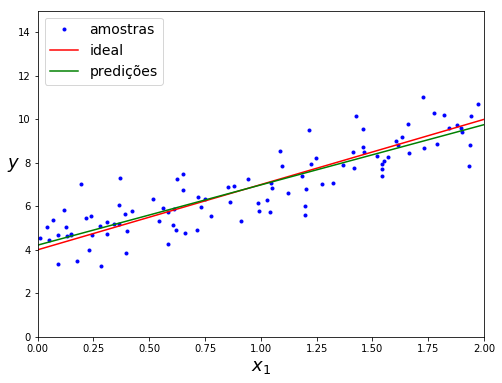

In [6]:
X_test = np.linspace(0.0, 2.0, num=100).T
X_test_b = np.c_[np.ones((len(X_test), 1)), X_test]
y_test = X_test_b.dot(theta_best)

plt.figure(figsize=(8,6))
plt.plot(X, y, "b.", label='amostras')
plt.plot(X_aux, y_aux, "r", label='ideal')
plt.plot(X_test, y_test, "g-", label='predições')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

Vamos comparar nosso preditor com o regressor linear do scikit-learn:

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

Resultados identicos!

**Atividade:** Escreva seu próprio regressor linear no framework do scikit-learn. Teste o regressor.

In [8]:
class NormalEquationLinearRegression():
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        return np.zeros(X.shape[0])
    
my_reg = NormalEquationLinearRegression()
my_reg.fit(X, y)
y_pred = my_reg.predict(X_test)
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#  Gradient Descent

Um outro método de treinamento de uma regressão linear é o método do máximo declive (*gradient descent*). Este método também serve para outros regressores e classificadores, é bastante genérico - usaremos bastante o gradient descent em redes neurais!

Este método se baseia na observação seguinte:

- O gradiente da função de erro médio é um vetor no espaço de características que aponta na direção de maior crescimento do erro.
- Logo, se desejo achar os parâmetros que minimizam o erro, basta andar na direção contrária do gradiente do erro!

Ou seja, partindo de um "chute" aleatório $\mathbf{\theta}_{0}$ dos valores dos parâmetros, vamos iterativamente melhorar nossos parâmetros através de pequenos incrementos neste na direção oposta ao gradiente da função de erro:

$$
\mathbf{\theta}_{i + 1} = \mathbf{\theta}_{i} - \eta \nabla_{\mathbf{\theta}} \varepsilon^2\left(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}, \mathbf{\theta}_{i}\right)
$$

O **hiperparâmetro** $\eta$ é chamado de *passo de aprendizado* (*learning step*) do algoritmo.

Continuamos iterando através desta fórmula até que não tenhamos mais mudanças significativas em $\mathbf{\theta}$, ou seja: para uma pequena tolerância $\epsilon > 0$

$$
\left| \, \mathbf{\theta}_{i + 1} - \mathbf{\theta}_{i} \, \right| < \epsilon
$$

O **hiperparâmetro** $\epsilon$ controla a precisão desejada na solução final. Se a tolerância for muito pequena pode ser que o algoritmo não convirja rapidamente. Neste caso é comum definir um número máximo de iterações através de outro **hiperparâmetro** $\text{max_iter}$.

**Atividade:** Estude o material do livro texto (Géron), capítulo 4 e responda:

- Qual a diferença entre batch gradient descent, stochastic gradient descent, e mini-batch gradient descent?
- O que acontece quando $\eta$ é muito pequeno?
- O que acontece quando $\eta$ é muito grande?
- Quais as classes do scikit-learn que implementam regressão linear usando a equação normal no treinamento? Quais usam gradient descent em alguma de suas formas?

**R:**

**Atividade desafio:**

- O que é "simulated annealing"? Como você usaria o conceito de simulated annealing para otimizar um modelo de machine learning?

# Regressão polinomial

E se os dados não se ajustam a uma linha reta (ou um hiperplano, no caso geral)? Considere o seguinte problema:

In [9]:
np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

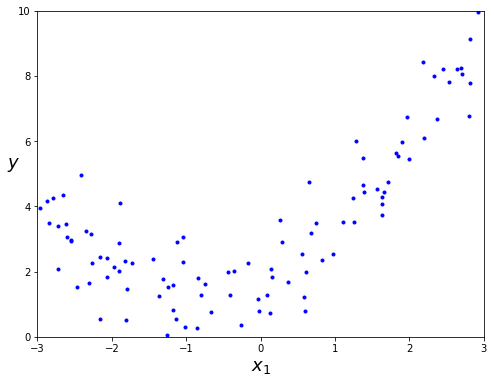

In [10]:
plt.figure(figsize=(8,6))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

Obviamente não podemos atingir um bom *fit* com uma linha reta! A solução para nosso problema é criar novas *features* com valores polinomiais:

In [11]:
print('Tamanho original da matriz de amostras: {}'.format(X.shape))
print('Algumas das amostras originais:\n{}'.format(X[:5]))

# Adicionando uma coluna de 1s.
X_b = np.c_[np.ones((m, 1)), X, X**2]

print('Tamanho da matriz de amostras aumentada: {}'.format(X_b.shape))
print('Algumas das amostras da matriz aumentada:\n{}'.format(X_b[:5]))

Tamanho original da matriz de amostras: (100, 1)
Algumas das amostras originais:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
Tamanho da matriz de amostras aumentada: (100, 3)
Algumas das amostras da matriz aumentada:
[[ 1.         -0.75275929  0.56664654]
 [ 1.          2.70428584  7.3131619 ]
 [ 1.          1.39196365  1.93756281]
 [ 1.          0.59195091  0.35040587]
 [ 1.         -2.06388816  4.25963433]]


Usamos novamente a equação normal para achar os parâmetros ótimos (ou o gradient descent também serve!)

In [12]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[1.78134581],
       [0.93366893],
       [0.56456263]])

Agora vamos ver como ficou nosso *fit*:

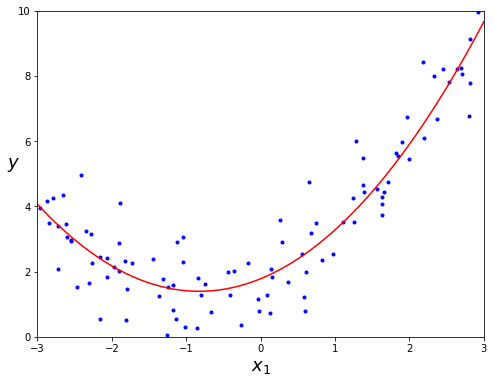

In [13]:
X_test = np.linspace(-3, 3, num=100).T
X_test_b = np.c_[np.ones((m, 1)), X_test, X_test**2]
y_test = X_test_b.dot(theta_best)

plt.figure(figsize=(8,6))
plt.plot(X, y, "b.")
plt.plot(X_test, y_test, "r-")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

Para criar *features* polinomiais de um grau qualquer em scikit-learn podemos usar a classe ``PolynomialFeatures``:

In [14]:
from sklearn.preprocessing import PolynomialFeatures

# Nota: include_bias=False porque o bias (termo constante) já estará incluso no regressor linear.
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

print(X.shape)
print(X_poly.shape)

(100, 1)
(100, 2)


In [15]:
print(X[0])
print(X_poly[0])

[-0.75275929]
[-0.75275929  0.56664654]


Podemos então fazer um regressor linear com estes novos dados:

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Compare os resultados obtidos aqui com aqueles da equação normal obtidos anteriormente.